<a href="https://colab.research.google.com/github/KieuSonTung/Food-Delivery-Database-Management/blob/main/DataPreparationFinal/Data_Preparation_Final_LGBM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [241]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)


In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import plotly.express as px
sns.set()

In [244]:
plt.style.use('seaborn')

## Load the dateset

In [245]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/car train.csv', sep=';')
train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,First Owner,21.19 kmpl,1396 CC,88.76 bhp,219.66nm@ 1500-2750rpm,5.0
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,Second Owner,12.55 kmpl,2982 CC,168.5 bhp,360Nm@ 1400-3200rpm,7.0
3,Hyundai Verna 1.6 VTVT SX,2015,795000,35000,Petrol,Individual,Manual,First Owner,17.01 kmpl,1591 CC,121.3 bhp,154.9Nm@ 4200rpm,5.0
4,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969 CC,190 bhp,400Nm,5.0


In [246]:
df = train.copy()
df = df.dropna()
df = df.reset_index(drop=True)

## Overview

In [247]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6000 non-null   object 
 1   year           6000 non-null   int64  
 2   selling_price  6000 non-null   int64  
 3   km_driven      6000 non-null   int64  
 4   fuel           6000 non-null   object 
 5   seller_type    6000 non-null   object 
 6   transmission   6000 non-null   object 
 7   owner          6000 non-null   object 
 8   mileage        5841 non-null   object 
 9   engine         5841 non-null   object 
 10  max_power      5846 non-null   object 
 11  torque         5840 non-null   object 
 12  seats          5841 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 609.5+ KB


We are modifying some fields 

## Fuel


In [248]:
train['fuel'].value_counts()

Diesel    3265
Petrol    2664
CNG         44
LPG         27
Name: fuel, dtype: int64

We are going to replace CNG and LPG with Petrol since the number of their observations is too little

In [249]:
train['fuel'] = train['fuel'].replace(['CNG', 'LPG'], 'Petrol')
train.fuel.value_counts()

Diesel    3265
Petrol    2735
Name: fuel, dtype: int64

In [250]:
Fuel = train[['fuel']]
Fuel = pd.get_dummies(Fuel, drop_first=True)
Fuel.head()

,fuel_Petrol
0,0
1,0
2,0
3,1
4,0


Let's take a look at the **selling_price** distribution of each **fuel** type

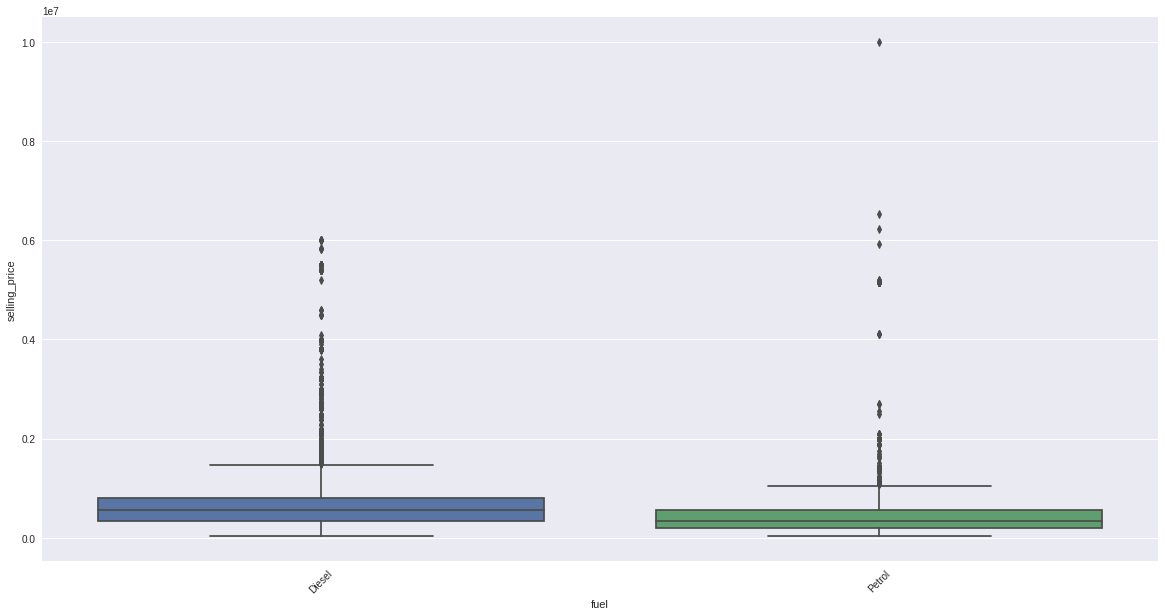

In [251]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(x='fuel', y='selling_price', data=train)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

We can see that there is an outlier, its price is more than 10 million so we are going to remove it

## Brand

In [252]:
train['brand'] = train['name'].apply(lambda x: x.split()[0])
train.brand.value_counts()

Maruti           1792
Hyundai          1034
Mahindra          595
Tata              546
Toyota            366
Honda             335
Ford              288
Chevrolet         170
Renault           164
Volkswagen        136
BMW                83
Skoda              77
Nissan             60
Jaguar             52
Volvo              50
Datsun             49
Mercedes-Benz      44
Fiat               38
Audi               30
Lexus              27
Jeep               23
Mitsubishi         12
Land                6
Isuzu               5
Force               5
Kia                 4
Ambassador          3
Daewoo              2
Opel                1
Ashok               1
MG                  1
Peugeot             1
Name: brand, dtype: int64

Since there are a lor of brands, we are going to devide those brands into two categories: Asia car and Euro car

In [253]:
asia_car = ['Maruti', 'Hyundai', 'Toyota', 'Tata', 'Honda', 'Nissan', 'Datsun', 
            'Mitsubishi', 'Isuzu', 'Kia', 'Daewoo']
train['brand'] = train['name'].apply(lambda x: 'Asia' if x.split()[0] in asia_car else 'Euro')
'''
1: Asia brand
2: Euro brand
'''
train.brand.value_counts()

Asia    4205
Euro    1795
Name: brand, dtype: int64

In [254]:
Brand = train[['brand']]
Brand = pd.get_dummies(Brand, drop_first=True)
Brand.head()

,brand_Euro
0,0
1,0
2,0
3,0
4,1


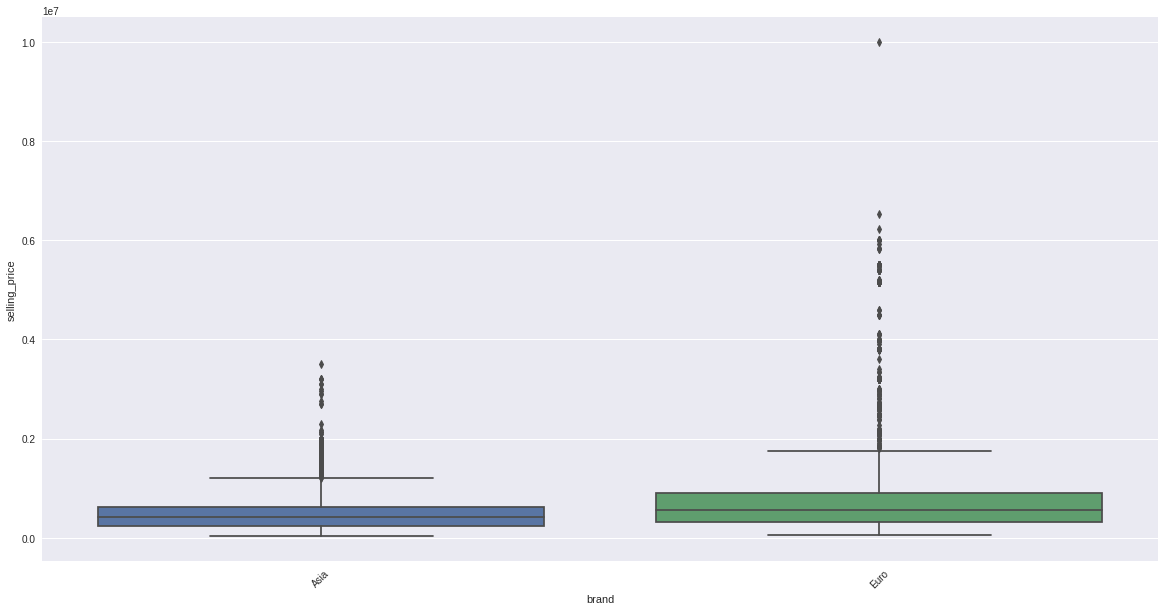

In [255]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(x='brand', y='selling_price', data=train)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

We can see that the price range of the European car tend to be wider than Asian car

## Year

In [256]:
train['year'].value_counts().sort_index()

1983      1
1994      1
1995      2
1996      2
1997     10
1998      7
1999     11
2000     14
2001      8
2002     24
2003     39
2004     46
2005     73
2006     86
2007    130
2008    159
2009    165
2010    290
2011    448
2012    485
2013    493
2014    470
2015    572
2016    630
2017    752
2018    608
2019    425
2020     49
Name: year, dtype: int64

Since most of the cars in the dataset are quite new (mostly around 2016, 2017), we are going to devide the **year** column into two categories: Before 2015 and After 2015

In [257]:
train['class_year'] = train['year'].apply(lambda x: 'before_2015' if x <= 2015 else 'after_2015')
train['class_year'].value_counts()

before_2015    3536
after_2015     2464
Name: class_year, dtype: int64

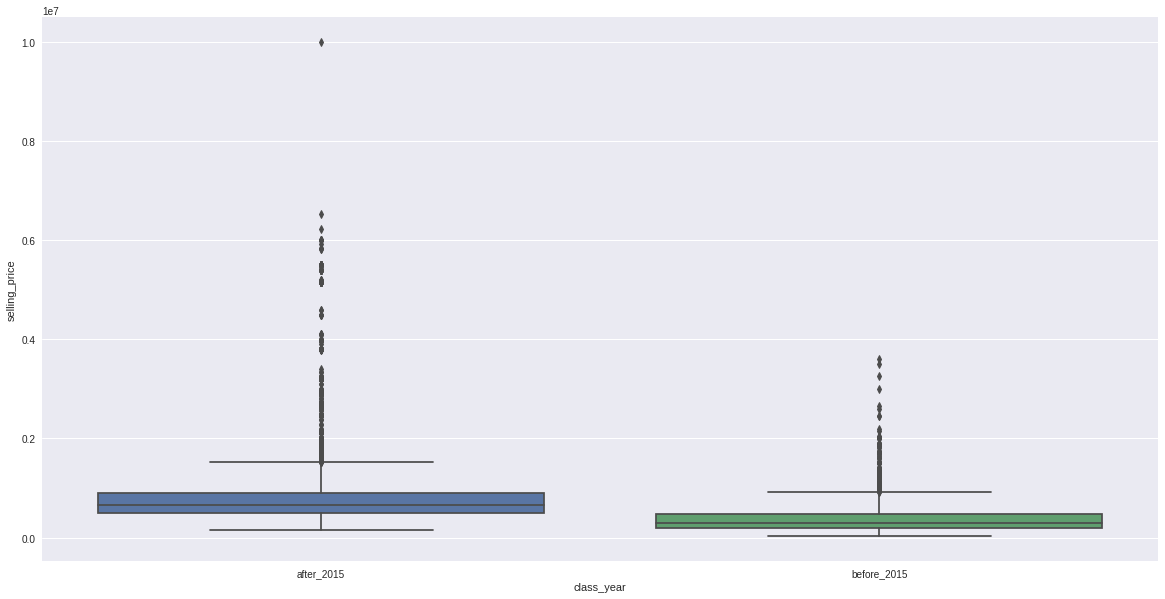

In [258]:
# Year/ Price

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(x='class_year', y='selling_price', data=train)
locs, labels = plt.xticks()
plt.show()

## Seller Type

In [259]:
train.seller_type.value_counts()

Individual          5006
Dealer               820
Trustmark Dealer     174
Name: seller_type, dtype: int64

In [260]:
train['seller_type'].replace({'Trustmark Dealer': 'Dealer'}, inplace=True)

In [261]:
Seller = train[['seller_type']]
Seller = pd.get_dummies(Seller, drop_first=True)
Seller.head()

,seller_type_Individual
0,1
1,1
2,1
3,1
4,1


## Owner

In [262]:
train['owner'].value_counts()

First Owner             3904
Second Owner            1558
Third Owner              414
Fourth & Above Owner     119
Test Drive Car             5
Name: owner, dtype: int64

In [263]:
train['owner'].replace(['Fourth & Above Owner', 'Test Drive Car', 'Third Owner', 'Second Owner'], 'Second & Others', inplace=True)

In [264]:
train['owner'].value_counts()

First Owner        3904
Second & Others    2096
Name: owner, dtype: int64

In [265]:
Owner = train[['owner']]
Owner = pd.get_dummies(Owner, drop_first=True)
Owner.head()

,owner_Second & Others
0,0
1,0
2,1
3,0
4,0


## Mileage

In [266]:
df['mileage'] = df['mileage'].apply(lambda x: float(x.split()[0]) if str(x).endswith('kmpl') else float(x.split()[0]) * 1.4) 
mean_mil = np.mean(df.mileage)

train.mileage = train.mileage.fillna('0')
train['mileage'] = train['mileage'].apply(lambda x: float(x.split()[0]) if str(x).endswith('kmpl') else float(x.split()[0]) * 1.4) 
train.mileage = train.mileage.replace(0, mean_mil)
train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,class_year
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,First Owner,21.50,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0,Asia,after_2015
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,First Owner,21.19,1396 CC,88.76 bhp,219.66nm@ 1500-2750rpm,5.0,Asia,after_2015
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,Second & Others,12.55,2982 CC,168.5 bhp,360Nm@ 1400-3200rpm,7.0,Asia,before_2015
3,Hyundai Verna 1.6 VTVT SX,2015,795000,35000,Petrol,Individual,Manual,First Owner,17.01,1591 CC,121.3 bhp,154.9Nm@ 4200rpm,5.0,Asia,before_2015
4,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.00,1969 CC,190 bhp,400Nm,5.0,Euro,after_2015


We can see that some observations have different measuring units, so we have to convert them 

## Transmission

In [267]:
train.transmission.value_counts()

Manual       5228
Automatic     772
Name: transmission, dtype: int64

In [268]:
Trans = train[['transmission']]
Trans = pd.get_dummies(Trans, drop_first=True)
Trans.head()

,transmission_Manual
0,1
1,1
2,0
3,1
4,0


## Engine

In [269]:
df['engine'] = df['engine'].apply(lambda x: float(x.split()[0])) 
mean_en = np.mean(df.engine)

train.engine = train.engine.fillna('0')
train['engine'] = train['engine'].apply(lambda x: float(x.split()[0]))
train.engine = train.engine.replace(0, mean_en)
train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,class_year
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,First Owner,21.50,1497.0,108.5 bhp,260Nm@ 1500-2750rpm,5.0,Asia,after_2015
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,First Owner,21.19,1396.0,88.76 bhp,219.66nm@ 1500-2750rpm,5.0,Asia,after_2015
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,Second & Others,12.55,2982.0,168.5 bhp,360Nm@ 1400-3200rpm,7.0,Asia,before_2015
3,Hyundai Verna 1.6 VTVT SX,2015,795000,35000,Petrol,Individual,Manual,First Owner,17.01,1591.0,121.3 bhp,154.9Nm@ 4200rpm,5.0,Asia,before_2015
4,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.00,1969.0,190 bhp,400Nm,5.0,Euro,after_2015


## Max Power

In [270]:
df['max_power'] = df['max_power'].apply(lambda x: float(x.split()[0])) 
mean_mp = np.mean(df.max_power)

train.max_power = train.max_power.fillna('0')
train.max_power = train.max_power.apply(lambda x: x.split()[0])
train.max_power = train.max_power.replace('bhp', '0')
train.max_power = train.max_power.apply(lambda x: float(x))
train.max_power = train.max_power.replace(0, mean_mp)
train.head()


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,class_year
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,First Owner,21.50,1497.0,108.50,260Nm@ 1500-2750rpm,5.0,Asia,after_2015
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,First Owner,21.19,1396.0,88.76,219.66nm@ 1500-2750rpm,5.0,Asia,after_2015
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,Second & Others,12.55,2982.0,168.50,360Nm@ 1400-3200rpm,7.0,Asia,before_2015
3,Hyundai Verna 1.6 VTVT SX,2015,795000,35000,Petrol,Individual,Manual,First Owner,17.01,1591.0,121.30,154.9Nm@ 4200rpm,5.0,Asia,before_2015
4,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.00,1969.0,190.00,400Nm,5.0,Euro,after_2015


## Seats

In [271]:
train.seats = train.seats.fillna(train.seats.mode())

## Torque

In [272]:
train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,class_year
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,First Owner,21.50,1497.0,108.50,260Nm@ 1500-2750rpm,5.0,Asia,after_2015
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,First Owner,21.19,1396.0,88.76,219.66nm@ 1500-2750rpm,5.0,Asia,after_2015
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,Second & Others,12.55,2982.0,168.50,360Nm@ 1400-3200rpm,7.0,Asia,before_2015
3,Hyundai Verna 1.6 VTVT SX,2015,795000,35000,Petrol,Individual,Manual,First Owner,17.01,1591.0,121.30,154.9Nm@ 4200rpm,5.0,Asia,before_2015
4,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.00,1969.0,190.00,400Nm,5.0,Euro,after_2015


In [273]:
import re

def torque_processing(torque):
#     fix here if error
    if type(torque) == int and torque == 0:
        return 0,0
#     -----------
    element = torque.split()
    power = []
    for e in element:
        tor = re.findall("(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?", e)
        power.append(tor)
    power = [tor for tor in power if tor]
    if 'kgm@' in torque:
        # 1kgm@ = 10nm
        power[0] = round(float(power[0][0]) * 10, 1)
    else:
        power[0] = round(float(power[0][0]), 1)
    if len(power) == 2:
        if len(power[1]) == 2:
            power[1] = round(np.mean([float(i) for i in power[1]]), 1)
        else:
            power[1] = round(float(power[1][0]), 1)
    if len(power) == 1:
        power.append(0)
    if power[1] < 1000:
    # print('SMALLER THAN 1000',power[1])
        power[1] = round(power[1] * 1000, 1)
    return power[0], power[1]

train.torque = train.torque.fillna('0')

train['torque'] = train['torque'].str.replace(',','.')
for i in range(train.shape[0]):
    torque, rpm = torque_processing(train['torque'].iloc[i])
    train.at[i, 'torque'] = torque
    train.at[i, 'rpm'] = rpm
    
train.torque

0         260
1       219.7
2         360
3       154.9
4         400
        ...  
5995       90
5996       77
5997      114
5998      180
5999      200
Name: torque, Length: 6000, dtype: object

In [274]:
train.torque = train.torque.apply(lambda x: float(x))

In [275]:
df = train.copy()
mean_torque = df[df.torque!=0].torque.mean()
train.torque = train.torque.replace(0, mean_torque)

In [276]:
train.drop(columns='rpm', inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6000 non-null   object 
 1   year           6000 non-null   int64  
 2   selling_price  6000 non-null   int64  
 3   km_driven      6000 non-null   int64  
 4   fuel           6000 non-null   object 
 5   seller_type    6000 non-null   object 
 6   transmission   6000 non-null   object 
 7   owner          6000 non-null   object 
 8   mileage        6000 non-null   float64
 9   engine         6000 non-null   float64
 10  max_power      6000 non-null   float64
 11  torque         6000 non-null   float64
 12  seats          5841 non-null   float64
 13  brand          6000 non-null   object 
 14  class_year     6000 non-null   object 
dtypes: float64(5), int64(3), object(7)
memory usage: 703.2+ KB


## Final Dataset


In [277]:
yprop = 'selling_price'
xprop = 'engine'
h= 'transmission'
px.scatter(train, x=xprop, y=yprop, color=h, marginal_y="violin", marginal_x="box", trendline="ols", template="simple_white")


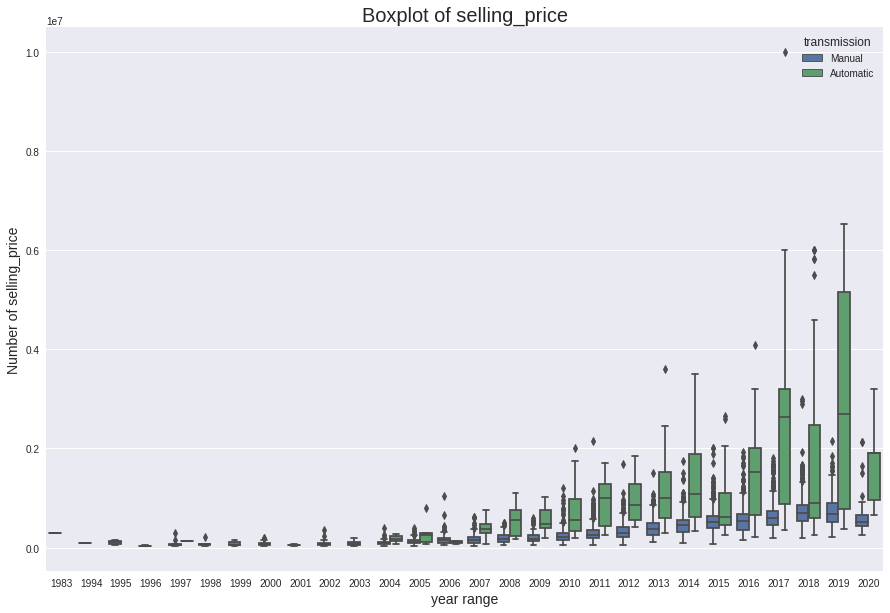

In [278]:
plt.figure(figsize=(15,10))
xprop = 'year'
yprop = 'selling_price'
sns.boxplot(data=train, x=xprop, y=yprop, hue='transmission')
plt.xlabel('{} range'.format(xprop), size=14)
plt.ylabel('Number of {}'.format(yprop), size=14)
plt.title('Boxplot of {}'.format(yprop), size=20)
plt.show()

We can see that even though the number of **automatic** cars is less than **manual** but the price of **automatic** is more costly

In [279]:
train.drop(columns={'name', 'fuel', 'seller_type', 'transmission', 'owner', 
                    'brand', 'class_year', 'km_driven'}, inplace=True)
train.head()

,year,selling_price,mileage,engine,max_power,torque,seats
0,2018,850000,21.50,1497.0,108.50,260.0,5.0
1,2018,750000,21.19,1396.0,88.76,219.7,5.0
2,2015,1500000,12.55,2982.0,168.50,360.0,7.0
3,2015,795000,17.01,1591.0,121.30,154.9,5.0
4,2019,3800000,18.00,1969.0,190.00,400.0,5.0


In [280]:
ftrain = pd.concat([train, Brand, Fuel, Seller, Owner], axis=1)
ftrain = ftrain.drop(5537)
# ftrain = ftrain.drop_duplicates()
ftrain.head()

,year,selling_price,mileage,engine,max_power,torque,seats,brand_Euro,fuel_Petrol,seller_type_Individual,owner_Second & Others
0,2018,850000,21.50,1497.0,108.50,260.0,5.0,0,0,1,0
1,2018,750000,21.19,1396.0,88.76,219.7,5.0,0,0,1,0
2,2015,1500000,12.55,2982.0,168.50,360.0,7.0,0,0,1,1
3,2015,795000,17.01,1591.0,121.30,154.9,5.0,0,1,1,0
4,2019,3800000,18.00,1969.0,190.00,400.0,5.0,1,0,1,0


In [281]:
ftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    5999 non-null   int64  
 1   selling_price           5999 non-null   int64  
 2   mileage                 5999 non-null   float64
 3   engine                  5999 non-null   float64
 4   max_power               5999 non-null   float64
 5   torque                  5999 non-null   float64
 6   seats                   5840 non-null   float64
 7   brand_Euro              5999 non-null   uint8  
 8   fuel_Petrol             5999 non-null   uint8  
 9   seller_type_Individual  5999 non-null   uint8  
 10  owner_Second & Others   5999 non-null   uint8  
dtypes: float64(5), int64(2), uint8(4)
memory usage: 398.4 KB


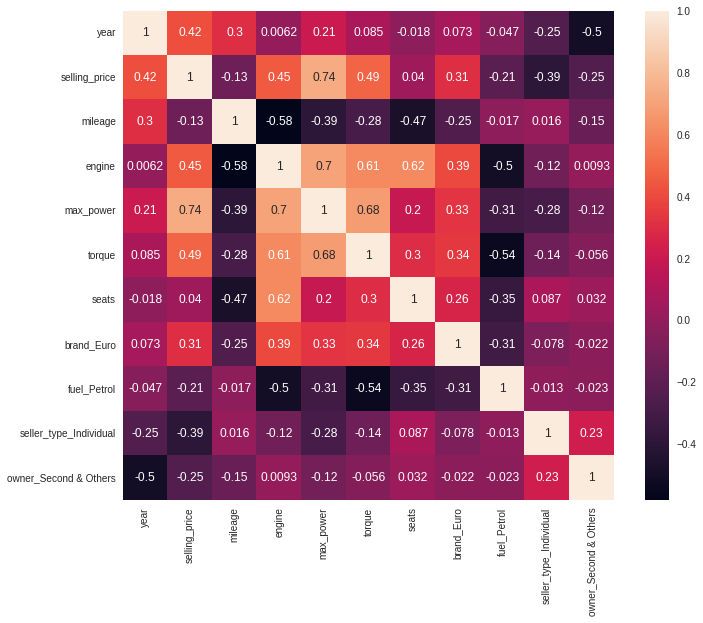

In [282]:
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ftrain.corr(), annot=True)

We can see that column **km_driven** is negatively correlated with **selling_price** so we are dropping **km_driven**

# Build Model

In [283]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [284]:
X = ftrain.drop(columns='selling_price')
y = ftrain['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [285]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    5999 non-null   int64  
 1   mileage                 5999 non-null   float64
 2   engine                  5999 non-null   float64
 3   max_power               5999 non-null   float64
 4   torque                  5999 non-null   float64
 5   seats                   5840 non-null   float64
 6   brand_Euro              5999 non-null   uint8  
 7   fuel_Petrol             5999 non-null   uint8  
 8   seller_type_Individual  5999 non-null   uint8  
 9   owner_Second & Others   5999 non-null   uint8  
dtypes: float64(5), int64(1), uint8(4)
memory usage: 351.5 KB


In [316]:
lgbt = LGBMRegressor()
param = {'num_leaves': (20, 30, 50), 'n_estimators': (5000, 7000), 'criterion': ['rmse'], 
         'learning_rate': (0.01, 0.05), 'num_leaves': (20, 30), 'max_depth': (9, 11, 15),
         'random_state': [42]}
reg_test = GridSearchCV(lgbt, param)
reg_test.fit(X_train, y_train)
reg_test.best_estimator_

LGBMRegressor(criterion='rmse', learning_rate=0.01, max_depth=9,
              n_estimators=7000, num_leaves=20, random_state=42)

In [318]:
y_pred = reg_test.predict(X_test)

print('MSE:', str(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)))
print('RMSE:', str(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)))
print('R-squared:', str(reg_test.score(X_test, y_test)))

MSE: 12517168623.677168
RMSE: 111880.15294804153
R-squared: 0.9817515437482263


In [396]:
reg1 = LGBMRegressor(criterion='rmse', max_depth=7, n_estimators=7000, num_leaves=40,
                    randsom_state=42, learning_rate=0.01, reg_lambda=0)

reg1.fit(X_train, y_train)

y_pred = reg1.predict(X_test)

print('MSE:', str(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)))
print('RMSE:', str(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)))
print('R-squared:', str(reg1.score(X_test, y_test)))

MSE: 12369920383.685175
RMSE: 111220.14378558038
R-squared: 0.9819662131472278


# Test model on the test set

In [290]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/car test.csv', sep=';')

In [291]:
test.head()

,Id,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,1,Skoda Rapid 1.6 MPI AT Elegance,2016,11000,Petrol,Dealer,Automatic,First Owner,14.3 kmpl,1598 CC,103.5 bhp,153Nm@ 3800rpm,5.0
1,2,Honda City i VTEC V,2017,35000,Petrol,Individual,Manual,First Owner,17.8 kmpl,1497 CC,117.3 bhp,145Nm@ 4600rpm,5.0
2,3,Hyundai Xcent 1.2 Kappa SX Option,2014,80000,Petrol,Individual,Manual,First Owner,19.1 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0
3,4,Mahindra Scorpio 2009-2014 SLE 7S BSIII,2014,145241,Diesel,Individual,Manual,First Owner,12.05 kmpl,2179 CC,120 bhp,290Nm@ 1800-2800rpm,7.0
4,5,Ford Ecosport 1.5 Diesel Titanium,2015,92651,Diesel,Dealer,Manual,First Owner,21.7 kmpl,1498 CC,98.96 bhp,215Nm@ 1750-2500rpm,5.0


In [292]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2128 non-null   int64  
 1   name          2128 non-null   object 
 2   year          2128 non-null   int64  
 3   km_driven     2128 non-null   int64  
 4   fuel          2128 non-null   object 
 5   seller_type   2128 non-null   object 
 6   transmission  2128 non-null   object 
 7   owner         2128 non-null   object 
 8   mileage       2066 non-null   object 
 9   engine        2066 non-null   object 
 10  max_power     2067 non-null   object 
 11  torque        2066 non-null   object 
 12  seats         2066 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 216.2+ KB


In [293]:
df = test.copy()
df = df.dropna()

# Fuel
test['fuel'] = test['fuel'].replace(['CNG', 'LPG'], 'Petrol')

Fuel2 = test[['fuel']]
Fuel2 = pd.get_dummies(Fuel2, drop_first=True)

# Brand
test['brand'] = test['name'].apply(lambda x: x.split()[0])

asia_car = ['Maruti', 'Hyundai', 'Toyota', 'Tata', 'Honda', 'Nissan', 'Datsun', 
            'Mitsubishi', 'Isuzu', 'Kia', 'Daewoo']
test['brand'] = test['name'].apply(lambda x: 'Asia' if x.split()[0] in asia_car else 'Euro')

Brand2 = test[['brand']]
Brand2 = pd.get_dummies(Brand2, drop_first=True)


# Seller Type
test['seller_type'].replace({'Trustmark Dealer': 'Dealer'}, inplace=True)

Seller2 = test[['seller_type']]
Seller2 = pd.get_dummies(Seller2, drop_first=True)

# Owner
test['owner'].replace(['Fourth & Above Owner', 'Test Drive Car', 'Third Owner', 'Second Owner'], 'Second & Others', inplace=True)

Owner2 = test[['owner']]
Owner2 = pd.get_dummies(Owner2, drop_first=True)

# Mileage
df['mileage'] = df['mileage'].apply(lambda x: str(x))
df['mileage'] = df['mileage'].apply(lambda x: float(x.split()[0]) if str(x).endswith('kmpl') else float(x.split()[0]) * 1.4) 
mean_mil = df[df.mileage!=0].mileage.mean()


test.mileage = test.mileage.fillna('0')
test['mileage'] = test['mileage'].apply(lambda x: float(x.split()[0]) if str(x).endswith('kmpl') else float(x.split()[0]) * 1.4) 
test.mileage = test.mileage.replace(0, mean_mil)
test.head()

# Transmission
Trans2 = test[['transmission']]
Trans2 = pd.get_dummies(Trans2, drop_first=True)

# Engine

test.engine = test.engine.apply(lambda x: str(x))
test.engine = test[train.engine.notnull()].engine.apply(lambda x: x.split()[0]).astype('float64')
mean_eng = test.engine.mean()
test.engine.fillna(mean_eng, inplace=True)

# Max Power
df['max_power'] = df['max_power'].apply(lambda x: float(x.split()[0])) 
mean_mp = np.mean(df.max_power)

test.max_power = test.max_power.fillna('0')
test.max_power = test.max_power.apply(lambda x: float(x.split()[0]))
test.max_power = test.max_power.replace(0, mean_mp)

# Seats
test.seats = test.seats.fillna(np.random.random_integers(10))

# Torque
import re

test.torque = test.torque.fillna('0')

test['torque'] = test['torque'].str.replace(',','.')
for i in range(test.shape[0]):
    torque, rpm = torque_processing(test['torque'].iloc[i])
    test.at[i, 'torque'] = torque
    test.at[i, 'rpm'] = rpm

test.torque = test.torque.apply(lambda x: float(x))
df = test.copy()
mean_torque = df[df.torque!=0].torque.mean()
test.torque = test.torque.replace(0, mean_torque)

# Final test dataset
test.drop(columns={'Id', 'name', 'fuel', 'seller_type', 'transmission', 'owner', 'brand', 'rpm', 'km_driven'}, inplace=True)
ftest = pd.concat([test, Brand2, Fuel2, Seller2, Owner2], axis=1)

ftest.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning:

This function is deprecated. Please call randint(1, 10 + 1) instead



,year,mileage,engine,max_power,torque,seats,brand_Euro,fuel_Petrol,seller_type_Individual,owner_Second & Others
0,2016,14.30,1598.0,103.50,153.0,5.0,1,1,0,0
1,2017,17.80,1497.0,117.30,145.0,5.0,0,1,1,0
2,2014,19.10,1197.0,82.00,114.0,5.0,0,1,1,0
3,2014,12.05,2179.0,120.00,290.0,7.0,1,0,1,0
4,2015,21.70,1498.0,98.96,215.0,5.0,1,0,0,0


In [294]:
ftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    2128 non-null   int64  
 1   mileage                 2128 non-null   float64
 2   engine                  2128 non-null   float64
 3   max_power               2128 non-null   float64
 4   torque                  2128 non-null   float64
 5   seats                   2128 non-null   float64
 6   brand_Euro              2128 non-null   uint8  
 7   fuel_Petrol             2128 non-null   uint8  
 8   seller_type_Individual  2128 non-null   uint8  
 9   owner_Second & Others   2128 non-null   uint8  
dtypes: float64(5), int64(1), uint8(4)
memory usage: 108.2 KB


In [397]:
predicted = reg1.predict(ftest)
Sample = pd.DataFrame(data={'Id': np.arange(1, ftest.shape[0]+1), 'Predicted': predicted})

Sample.head() 

,Id,Predicted
0,1,650061.917946
1,2,880470.910403
2,3,425608.202676
3,4,593578.951984
4,5,595863.930711


In [398]:
target = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/target1.csv')
print('RMSE:', str(metrics.mean_squared_error(y_true=target.Predicted, y_pred=Sample.Predicted, squared=False)))

RMSE: 134091.93362180277


In [368]:
Sample.to_csv('/content/drive/MyDrive/Colab Notebooks/Data Preparation/Kieu_Son_Tung_11195614_LGBM2', index=False)